# Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import tensorflow as tf


# EDA

In [3]:
train_dir= '/kaggle/input/dataset-face/combined_data/combined_train'
test_dir= '/kaggle/input/dataset-face/combined_data/combined_test'

In [4]:
def explore_dataset(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Train Dataset:", explore_dataset(train_dir))
print("Test Dataset:", explore_dataset(test_dir))

Train Dataset: {'Oval': 800, 'Heart': 800, 'Round': 800, 'Square': 800, 'Oblong': 800}
Test Dataset: {'Oval': 200, 'Heart': 210, 'Round': 200, 'Square': 200, 'Oblong': 200}


# Image Prepocessing

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
classes = [class_name for class_name in os.listdir(train_dir)]
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [6]:
train_df = create_df(train_dir)
test_df = create_df(test_dir)

In [7]:
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

In [8]:
# 2. Image Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 4000 validated image filenames belonging to 5 classes.
Found 1010 validated image filenames belonging to 5 classes.


# Modelling

In [25]:
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))
base_model.trainable = True


for layer in base_model.layers:
    if "block_14" in layer.name:  # Fine-tune from block_14 onwards
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])



In [26]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 320,000 (1.22 MB)

 Non-trainable params: 1,937,984 (7.39 MB)

In [27]:
optimizer = Adam(learning_rate=0.001)  # Reduce learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.90:
            self.model.stop_training = True
            print("\nReached 85% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

# Train Model

In [28]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback]
)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 535ms/step - accuracy: 0.2543 - loss: 2.1600 - val_accuracy: 0.2505 - val_loss: 1.9082
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 506ms/step - accuracy: 0.3640 - loss: 1.5998 - val_accuracy: 0.3089 - val_loss: 1.9659
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.4320 - loss: 1.4314 - val_accuracy: 0.3782 - val_loss: 1.5158
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.4871 - loss: 1.3050 - val_accuracy: 0.3634 - val_loss: 1.6799
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.5293 - loss: 1.2091 - val_accuracy: 0.3970 - val_loss: 1.5264
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.5398 - loss: 1.1351 - val_accuracy: 0.4406 - val_loss: 1.3534
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 500ms/step - accuracy: 0.5701 - loss: 1.0952 - val_accuracy: 0.4010 - val_loss: 1.6124
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 497ms/step - accuracy: 0.5926 - loss: 1

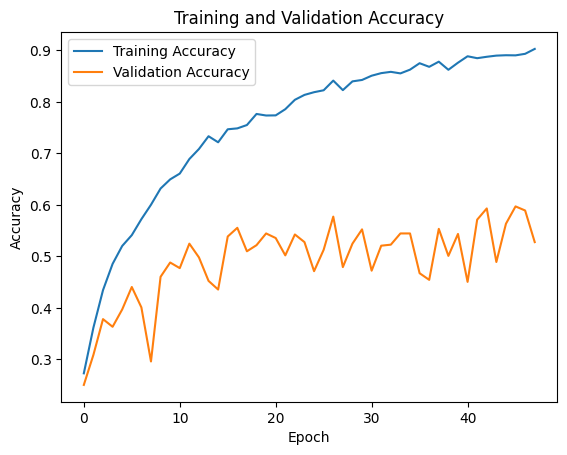

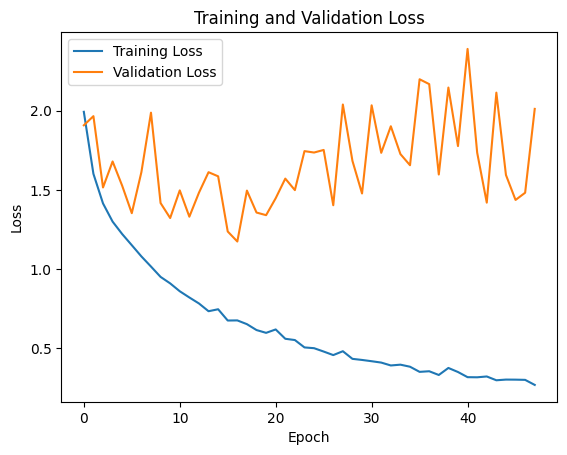

In [29]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.4841 - loss: 2.0246

Test Accuracy: 52.77%


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step


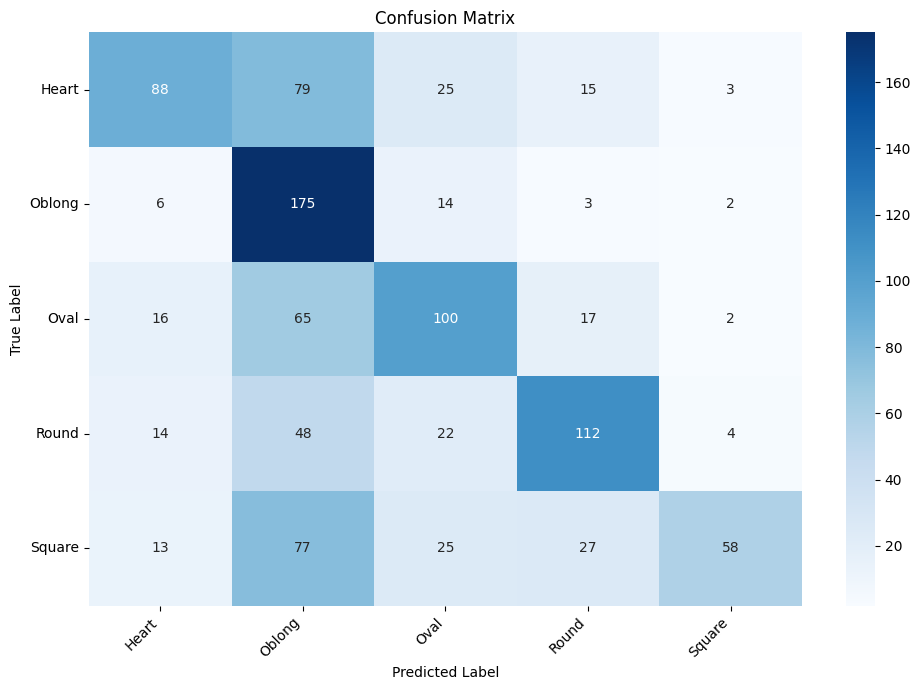

In [31]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

# Visualisasikan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

In [33]:
model.save('model_face_shape_V1.h5')